### AIDI 1002 Assignment 3
### Author: Ahmad Sayeb - 200534271

In [205]:
# ---------------- Libraries-----------------
import pandas as pd
import numpy as np
# ---------------- Plotting------------------
import matplotlib.pyplot as plt
# ---------------- Sklearn libraries---------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score, recall_score
# ---------------- Keras---------------------
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers
# ----------------Tensor-flow support--------
import tensorflow_addons as tfa
# -----------------Warnings------------------
#removing cuda warnings for gpu
import warnings
warnings.filterwarnings('ignore')

In [215]:
def load_csv(path: str) -> 'dataframe':
    '''
    Loads csv file into dataframe
    path: path to the file
    '''
    df = pd.read_csv(path)
    return df


def num_col_nan(df: 'dataframe'):
    '''
    replaces nan value in numerical columns with mode
    df: dataframe
    '''
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    col_num = df.select_dtypes(include=numerics)
    
    for col in col_num:
        df[col].replace([np.nan], df[col].mode()[0], inplace=True)

        
def cat_col_nan(df: 'dataframe'):
    '''
    replace nan value in categorical column with None string
    df: dataframe
    '''
    
    categorical = ['object']
    cat_columns = df.select_dtypes(include=categorical)
    
    for col in cat_columns:
        df[col].replace([np.nan], 'None', inplace=True)


def encoder(df: 'dataframe', train=True) -> 'dataframe':
    '''
    label encoding categorical data that are indep variable
    and one hot encode target variables
    df: dataframe
    '''
    label = LabelEncoder()
    hot = OneHotEncoder()
    categorical = ['object']
    cat_col = df.select_dtypes(include=categorical)
    if train:
        target = cat_col[['Var_1']]
        cat_col.drop(columns=['Var_1'], inplace=True)
    for col in cat_col:
        df[col] = label.fit_transform(df[col])
    
    if train:
        target = pd.get_dummies(target)
        df.drop(columns=['Var_1'], inplace=True)
        return pd.concat([df, target], axis=1)
    else:
        return df


def replacing_classes(row: 'object'):
    if row != 'Cat_4' and row != 'Cat_6':
        return 'Other'
    else:
        return row

def drop_cols(cols: list, df: 'dataframe'):
    '''
    drops specified columns
    col: list of columns
    df: dataframe
    '''
    print(f'dropping {cols}...')
    df.drop(columns=cols, inplace=True)
    
    
def pre_processing(df: 'dataframe', train=True):
    '''
    performs nan value replacement and encoding categorical values
    '''
    try:
        if train:
            print('dropping columns...')
            drop_cols(['ID', 'Segmentation','Age'], df)
        if not train:
            print('dropping ID column')
            drop_cols(['ID','Var_1','Age'], df)
        print('replacing numerical nans with mode...')
        num_col_nan(df)
        print('replacing categorical nans with None string...')
        cat_col_nan(df)
        if train:
            print('changing anything otehr than cat_6 and cat_4 to other...')
            df['Var_1'] = df['Var_1'].apply(replacing_classes)
        print('label encoding categorical data...')
        df = encoder(df, train)
        print('\033[1m' + 'SUCCESSFULLY PERFORMED PREPROCESSING' + '\033[0m')    
        return df
    
    except Exception as e:
        print('error occurred in pre-processing')
        print(e)
        return False

    
def train_validation_split(val_size: float, df: 'dataframe'):
    '''
    splits dataframe into train and validation and SHUFFLES
    test_size: size of the validation
    df: dataframe
    '''
    # Shuffle is set to true
    # Stratify is set to true
    df_dep = df[['Var_1_Cat_4','Var_1_Cat_6', 'Var_1_Other']]
    df_indep = df.drop(columns=['Var_1_Cat_4','Var_1_Cat_6', 'Var_1_Other'])
    X_train, X_valid, y_train, y_valid = train_test_split(
                                                        df_indep,
                                                        df_dep,
                                                        test_size=val_size, 
                                                        shuffle=True,
                                                        stratify=df_dep[['Var_1_Cat_4', 'Var_1_Cat_6', 'Var_1_Other']]
                                                        )
    
    return X_train, X_valid, y_train, y_valid


def min_max_scaler(df: 'dataframe'):
    '''
    normalize numerical data
    df: dataframe
    '''
    scaler = MinMaxScaler()
    col_num = ['Work_Experience', 'Family_Size']
    df[col_num] = scaler.fit_transform(df[col_num])

    
def build_neural_network():
    '''
    this function creates the deep neural network
    input_size: size of the input array
    '''
    model = Sequential()
    model.add(Dense(512, input_shape=(7,), kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128))
    model.add(Dropout(0.02))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tfa.metrics.F1Score(average='micro', num_classes=3),'accuracy'])
    return model


def fit_model(X_train: 'dataframe',
              y_train: 'dataframe',
              X_val: 'dataframe', 
              y_val: 'dataframe'
             ):
    '''
    This trains the model
    X_trian: training data
    '''
    model = Sequential()
    model.add(Dense(512, input_shape=(7,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tfa.metrics.F1Score(average='micro', num_classes=3),'accuracy'])
    print(model.summary())
    
    X_train_array = X_train.values
    y_train_array = y_train.values
    X_val_array = X_val.values
    y_val_array = y_val.values
    callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=200)
    history = model.fit(X_train_array,
                        y_train_array,
                        epochs=300,
                        verbose=1,
                        validation_data=(X_val_array, y_val_array),
                       callbacks=[callbacks])
    return history

In [216]:
def train_pipeline():
    '''
    performs all the necessary functions for the training
    dataset
    '''
    df = load_csv('archive/train.csv')
    df = pre_processing(df)
    X_train, X_valid, y_train, y_valid = train_validation_split(0.10, df)
    # min_max_scaler(X_train)
    # min_max_scaler(X_valid)
    history = fit_model(X_train, y_train, X_valid, y_valid)  
    return history

In [217]:
history = train_pipeline()

dropping columns...
dropping ['ID', 'Segmentation', 'Age']...
replacing numerical nans with mode...
replacing categorical nans with None string...
changing anything otehr than cat_6 and cat_4 to other...
label encoding categorical data...
SUCCESSFULLY PERFORMED PREPROCESSING
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_213 (Dense)           (None, 512)               4096      
                                                                 
 dense_214 (Dense)           (None, 256)               131328    
                                                                 
 dense_215 (Dense)           (None, 128)               32896     
                                                                 
 dropout_28 (Dropout)        (None, 128)               0         
                                                                 
 dense_216 (Dense)           (None, 64)  

In [109]:
def test_pipeline(model):
    '''performs all the necessary steps for the testing
    dataset
    '''
    df_test = load_csv('archive/test.csv')
    df_test = pre_processing(df_test, train=False)
    y_pred = model.predict(df_test.values)
    y_test = load_csv('archive/test.csv')[['Var_1']]
    y_test['Var_1'] = y_test['Var_1'].apply(replacing_classes)
    y_test = pd.get_dummies(y_test)
    # putting predictions in a list
    # as the index of max probability
    pred = list()
    for i in range(len(y_pred)):
        pred.append(np.argmax(y_pred[i]))
    # putting test target variables in a list
    test = list()
    y_test_arr = y_test.values
    for i in range(len(y_test_arr)):
         test.append(np.argmax(y_test_arr[i]))

In [111]:
test_pipeline(model)

dropping ID column
dropping ['ID', 'Var_1', 'Age']...
replacing numerical nans with mode...
replacing categorical nans with None string...
label encoding categorical data...
SUCCESSFULLY PERFORMED PREPROCESSING
83/83 [==============================] - 0s 548us/step


In [115]:
df_test

,Gender,Ever_Married,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,0,2,2,2,0.0,2,1.0
1,1,2,2,5,8.0,0,4.0
2,0,2,0,9,0.0,2,1.0
3,1,2,0,4,11.0,1,2.0
4,0,0,0,8,1.0,2,4.0
...,...,...,...,...,...,...,...
2622,1,0,0,5,9.0,2,4.0
2623,0,0,2,1,1.0,2,1.0
2624,0,0,2,3,1.0,2,2.0
2625,1,2,2,4,1.0,1,5.0


In [158]:
# Classification metrics for Test
print(f'f1_score for the test data is:', f1_score(pred, test, average='micro'))
print(f'recall for the test data is:', recall_score(pred, test, average='micro'))
print(f'accuracy for the test data is: {accuracy_score(pred, test)}')

f1_score for the test data is: 0.3121431290445375
recall for the test data is: 0.3121431290445375
accuracy for the test data is: 0.3121431290445375


In [200]:
X_train

,Gender,Ever_Married,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
5963,1,0,0,3,0.000000,2,0.375
4768,1,0,2,5,0.571429,2,0.375
4262,1,0,0,5,0.357143,2,0.500
1916,1,2,2,3,0.000000,1,0.125
139,0,2,2,0,0.285714,2,0.375
...,...,...,...,...,...,...,...
505,1,2,2,4,0.071429,2,0.250
7567,0,0,2,3,0.000000,2,0.125
705,0,2,2,0,0.071429,1,0.375
5673,1,2,2,0,0.571429,2,0.125


In [199]:
X_valid

,Gender,Ever_Married,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
5392,1,0,2,0,0.000000,2,0.000
2890,1,0,0,3,0.071429,2,0.375
2138,0,0,2,2,0.071429,2,0.125
1816,1,2,0,4,0.000000,1,0.125
7157,1,2,0,4,0.071429,1,0.375
...,...,...,...,...,...,...,...
5613,0,0,2,0,0.000000,2,0.250
4999,0,0,2,5,0.000000,2,0.375
2780,1,2,2,5,0.142857,0,0.125
2051,1,0,2,0,0.571429,2,0.125


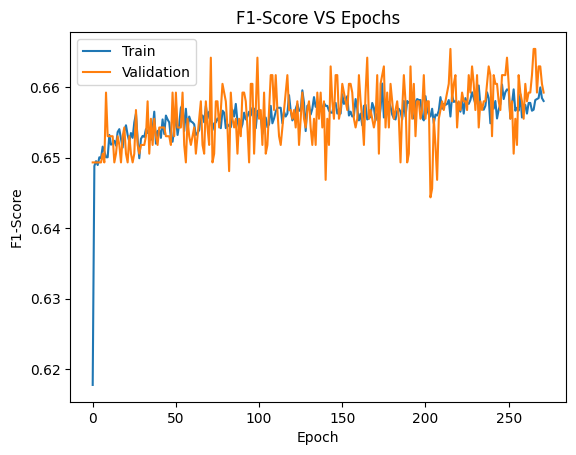

In [218]:
plt.plot(history.history['f1_score']) 
plt.plot(history.history['val_f1_score']) 
plt.title('F1-Score VS Epochs') 
plt.ylabel('F1-Score') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()

In [160]:
history